In [1]:
# %matplotlib inline
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, func, inspect

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [7]:
# Print all of the classes mapped to the Base
# print(list(Base.classes))
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year_start = datetime.date(2017, 8, 23) - datetime.timedelta(days=365)
prev_year_start

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= prev_year_start).\
    order_by(Measurement.date).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])
df["Date"] = pd.to_datetime(df["Date"])

# Sort the dataframe by date
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df.head()

,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


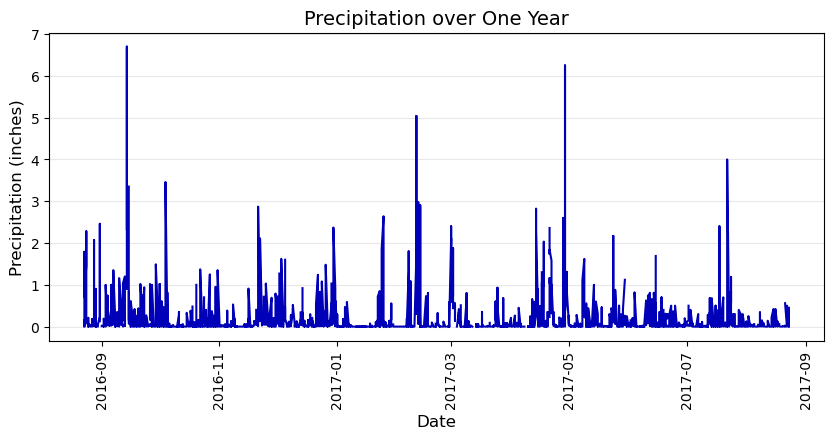

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,4))
plt.plot(df.Date, df.Precipitation, color="#0000B8")
plt.xticks(rotation=90)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (inches)", fontsize=12)
plt.title("Precipitation over One Year", fontsize=14)
plt.grid(color="lightgrey", axis="y", alpha=0.5)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.id)).all()
num_stations

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
top_station = most_active[0]
top_station
top_id = top_station[0]
top_id

'USC00519281'

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == top_id).all()
most_active_temps

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_last_year = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == top_id).\
    filter(Measurement.date >= prev_year_start).\
    all()

df_top = pd.DataFrame(top_station_last_year)
df_top.head()

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0


In [27]:
top_station_name = session.query(Station.station, Station.name).\
    filter(Station.station == top_id).all()
top_station_name

[('USC00519281', 'WAIHEE 837.5, HI US')]

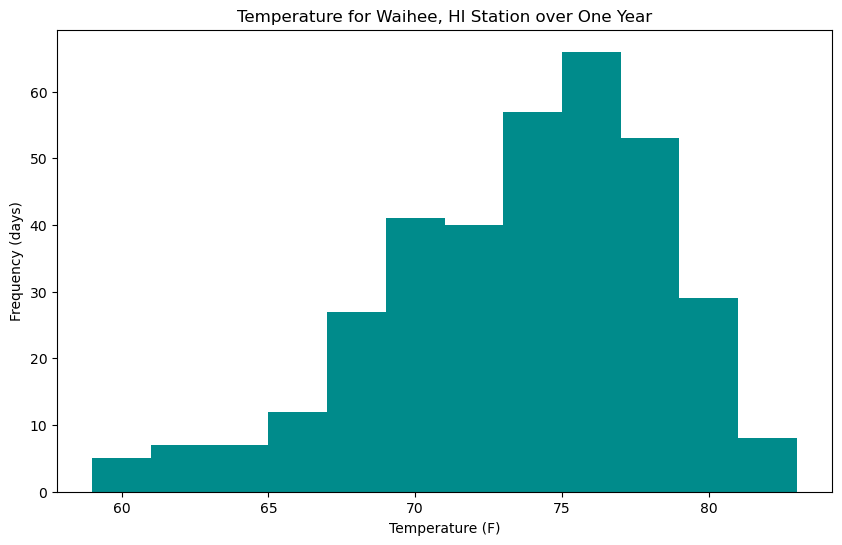

In [30]:
plt.figure(figsize=(10,6))
plt.hist(df_top.tobs, bins=12, color="#008B8B")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency (days)")
plt.title("Temperatures for Waihee, HI Station over One Year")
plt.show()

# Close Session

In [31]:
# Close Session
session.close()
